## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/training'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [7]:
il.items[9]

PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/4/57443.png')

In [8]:
defaults.cmap='binary'

In [9]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_png

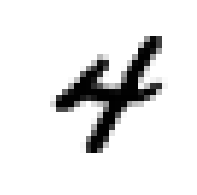

In [10]:
il[9].show()

In [11]:
splitDataset = il.split_by_folder(train='training', valid='testing')

In [12]:
splitDataset

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [13]:
(path/'training').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/7')]

In [17]:
labelLists = splitDataset.label_from_folder()

In [18]:
labelLists

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [19]:
x,y = labelLists.train[0]

4
torch.Size([1, 28, 28])


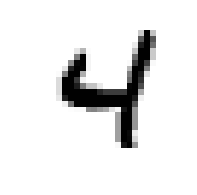

In [23]:
x.show()
print(y)
print(x.shape)

In [24]:
transforms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [25]:
labelLists = labelLists.transform(transforms)

In [53]:
batchSize = 128

In [54]:
# not using imagenet_stats because not using pretrained model
data = labelLists.databunch(bs=batchSize).normalize()

In [28]:
x,y = data.train_ds[9]

4


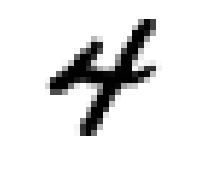

In [29]:
x.show()
print(y)

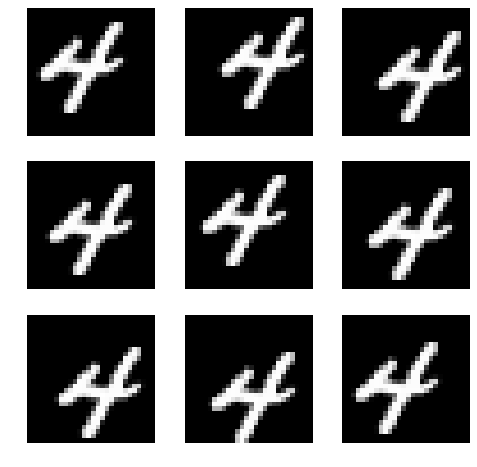

In [31]:
def _plot(i,j,ax): data.train_ds[9][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [55]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

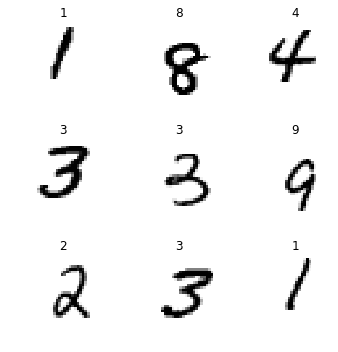

In [56]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [57]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [47]:
doc(nn.Conv2d)

In [58]:
model = nn.Sequential(
    conv(1, 8), # 14 <- Stride is 2, Images are 28x28 so it reduces it to 14x14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7 <- 14x14 is halved again, so 7x7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1 <- Final output layer needs to match the number of labels.
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [59]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [60]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [61]:
xb = xb.cuda()

In [62]:
model(xb).shape # Shape is batchsize and number of labels

torch.Size([128, 10])

In [63]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


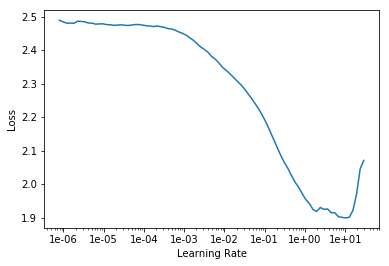

In [ ]:
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.211972,0.807050,0.764100,00:23
1,0.132340,0.101602,0.967600,00:24
2,0.066707,0.038935,0.987900,00:23


In [66]:
doc(conv_layer)

### Refactor

In [67]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [68]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [69]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.254423,0.287697,0.909900,00:23
1,0.193012,0.269135,0.915300,00:23
2,0.152728,0.104180,0.968400,00:23
3,0.136407,0.220148,0.932600,00:24
4,0.120150,0.072207,0.978100,00:23
5,0.104237,0.082737,0.974100,00:23
6,0.078003,0.045839,0.985800,00:23
7,0.062504,0.041027,0.987600,00:23
8,0.051607,0.029451,0.990900,00:23


### Resnet-ish

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [ ]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **kwargs)
    Resnet block of `nf` features.



In [ ]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


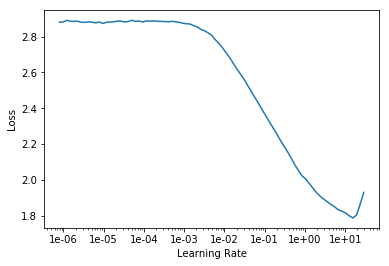

In [ ]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.248807,0.121582,0.972800
2,0.120927,0.360583,0.890300
3,0.104013,0.074916,0.977800
4,0.081181,0.065717,0.980000
5,0.068514,0.096448,0.967200
6,0.061274,0.087955,0.971800
7,0.051673,0.033911,0.989400
8,0.048090,0.033234,0.988800
9,0.039095,0.024638,0.992400
10,0.023670,0.021215,0.993400


In [ ]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin